In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../utils')
print(sys.path)
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
import pca_koopman_dir as km
from load_dataset import *
import argparse

import os
import yaml
import matplotlib.pyplot as plt

['/home/shiqi/code/model_combination_Argos/pca_from_formulation', '/home/shiqi/anaconda3/envs/torch/lib/python39.zip', '/home/shiqi/anaconda3/envs/torch/lib/python3.9', '/home/shiqi/anaconda3/envs/torch/lib/python3.9/lib-dynload', '', '/home/shiqi/anaconda3/envs/torch/lib/python3.9/site-packages', '../utils']


In [2]:
data_dir = "/home/shiqi/code/model_combination_Argos/data_dir/data_linear_1000"

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:

x_dataset = []
u_dataset = []
window_size = 150


for item in os.listdir(data_dir):
    data_file_path = os.path.join(data_dir, item)

    # Check if the file exists before trying to load it
    if data_file_path.endswith('.npy') and os.path.exists(data_file_path):
        data_dict = np.load(data_file_path, allow_pickle=True).item()
        x_data, _, u_data, _ = load_dataset(data_dict)
        x_dataset.append(x_data[:window_size])
        u_dataset.append(u_data[:window_size])
    else:
        print(f"File not found: {data_file_path}")

x_data = np.concatenate(x_dataset, axis = 0)
u_data = np.concatenate(u_dataset, axis = 0)

In [4]:
x_data.shape, u_data.shape

((7350, 6957), (7350, 2))

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 假设 x_data 已经是你的数据
# x_data.shape = (7350, 6957)

# 标准化数据
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_data)


In [6]:
x_scaled.shape

(7350, 6957)

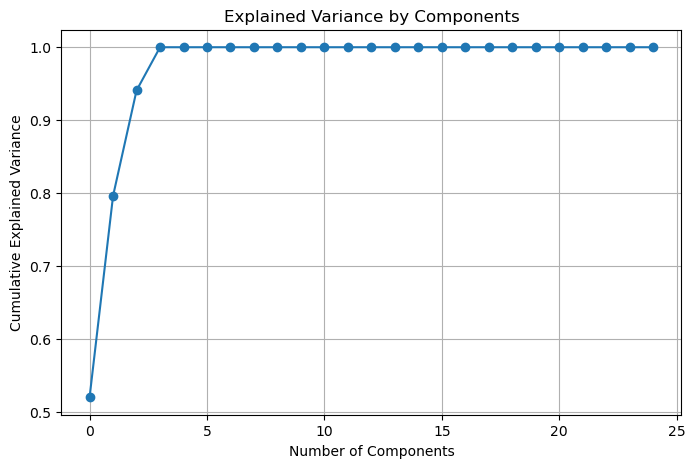

In [7]:
# 初始化PCA
pca = PCA(n_components=25)  # 选择一个初始的维度数目，例如100
x_pca = pca.fit_transform(x_scaled)

# 解释的方差比例
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# 可视化累积解释方差
plt.figure(figsize=(8, 5))
plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
# plt.yscale('log')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()


In [8]:
cumulative_explained_variance

array([0.52025087, 0.79624178, 0.9407649 , 0.99999469, 0.99999705,
       0.99999787, 0.99999852, 0.99999913, 0.99999937, 0.99999952,
       0.99999966, 0.99999975, 0.99999981, 0.99999986, 0.99999989,
       0.99999991, 0.99999993, 0.99999994, 0.99999995, 0.99999996,
       0.99999996, 0.99999997, 0.99999997, 0.99999998, 0.99999998])

In [9]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_data)

pca = PCA(n_components=10)
x_pca = pca.fit_transform(x_scaled)
print(f"PCA降维后的数据维度: {x_pca.shape}")
x_pca_reverse = np.zeros(x_pca.shape)
x_pca_reverse[:, 0] = x_pca[:, 0]
x_pca_reverse[:, 1] = - x_pca[:, 1]
x_pca_reverse[:, 2] = x_pca[:, 0]
x_pca_reverse[:, 3] = x_pca[:, 3]

x_reconstructed = pca.inverse_transform(x_pca)
x_reconstructed_reverse = pca.inverse_transform(x_pca_reverse)

reconstruction_error = mean_squared_error(x_scaled, x_reconstructed)
reconstruction_error_reverse = mean_squared_error(x_scaled, x_reconstructed_reverse)

print(f"resconstruction error（MSE）: {reconstruction_error}")
print(f"reconstruction error reverse（MSE）: {reconstruction_error_reverse}")


PCA降维后的数据维度: (7350, 10)
resconstruction error（MSE）: 4.806387052601246e-07
reconstruction error reverse（MSE）: 1.7687429413847586


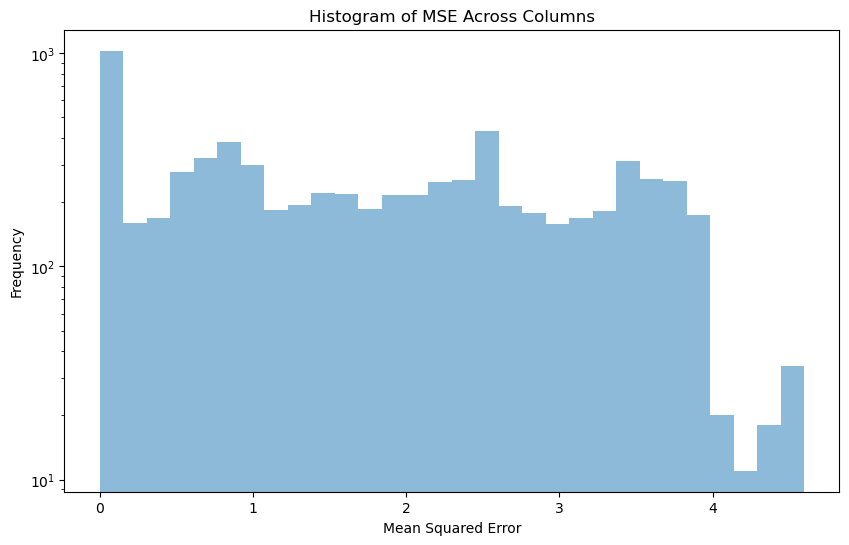

In [10]:
errors = np.mean((x_reconstructed_reverse - x_scaled) ** 2, axis=0)
data_norm = np.mean(x_scaled ** 2, axis=0)
errors = errors / data_norm

# Plotting the frequency of MSE values as a histogram
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, alpha=0.5)
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Histogram of MSE Across Columns')
plt.show()

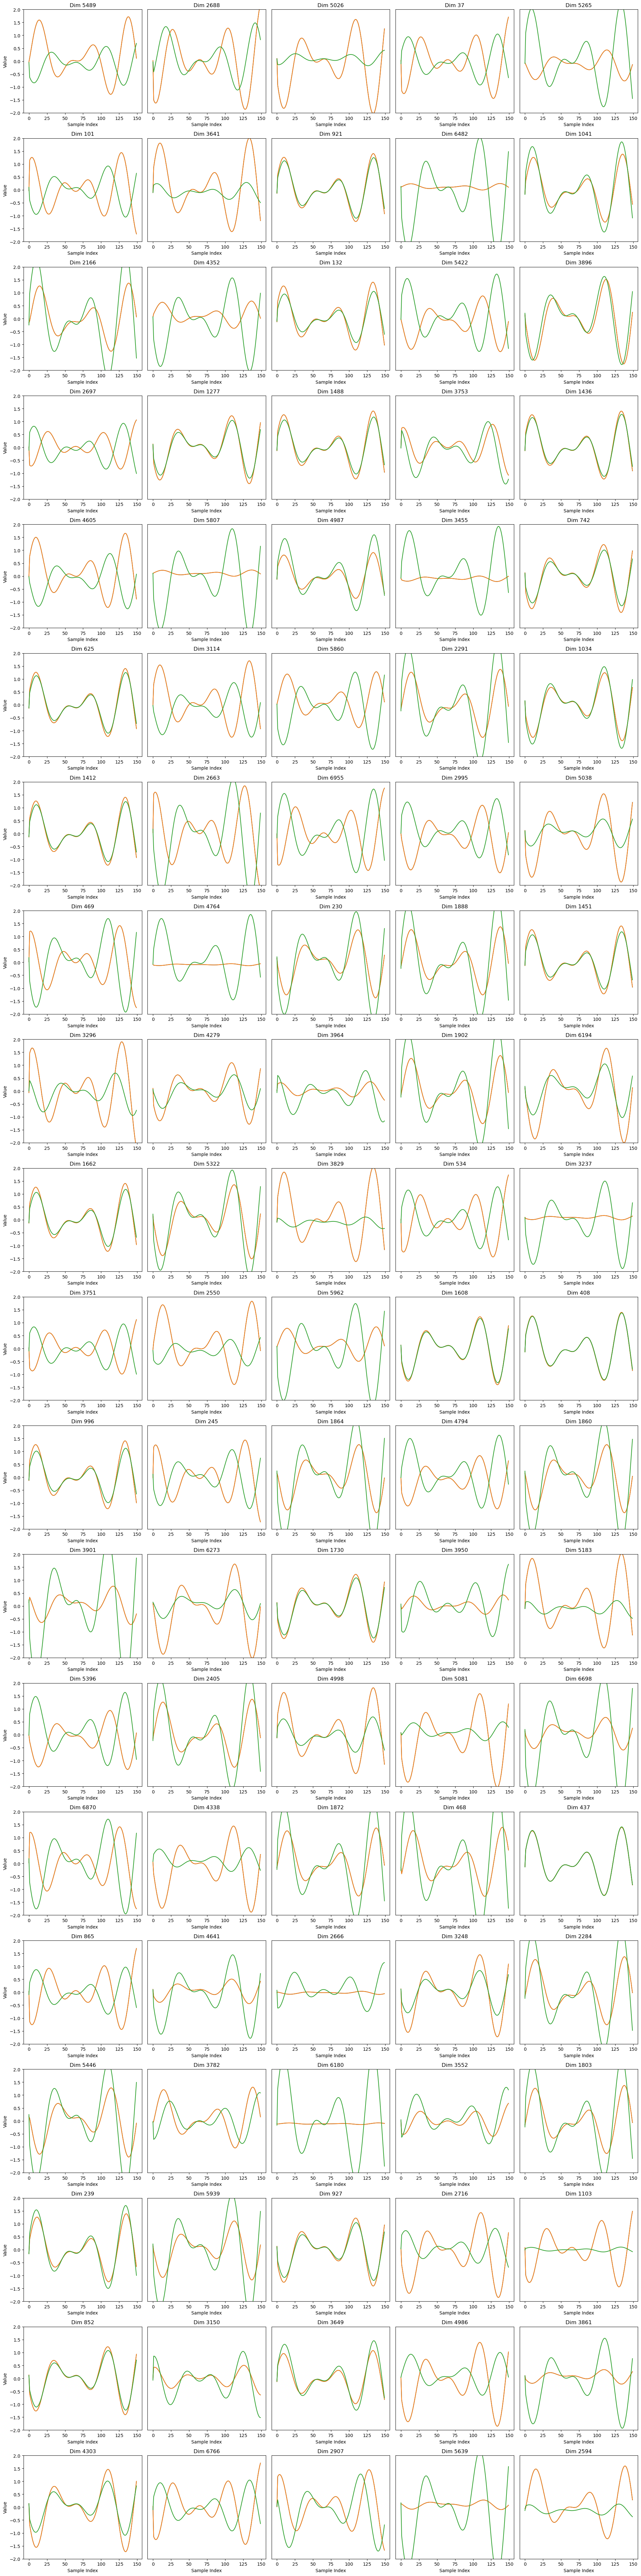

In [11]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)
selected_dimensions = np.random.choice(x_data.shape[1], 100, replace=False)

plt.figure(figsize=(20, 80))
k = 10
for i, dim in enumerate(selected_dimensions):
    plt.subplot(20, 5, i + 1)
    plt.plot(x_scaled[k*150:(k+1)*150, dim])
    plt.plot(x_reconstructed[k*150:(k+1)*150, dim])
    plt.plot(x_reconstructed_reverse[k*150:(k+1)*150, dim])
    
    plt.title(f"Dim {dim}")
    plt.xlabel("Sample Index")
    plt.ylim(-2, 2)
    if i % 5 == 0:
        plt.ylabel("Value")
    else:
        plt.yticks([])

plt.tight_layout()
plt.show()


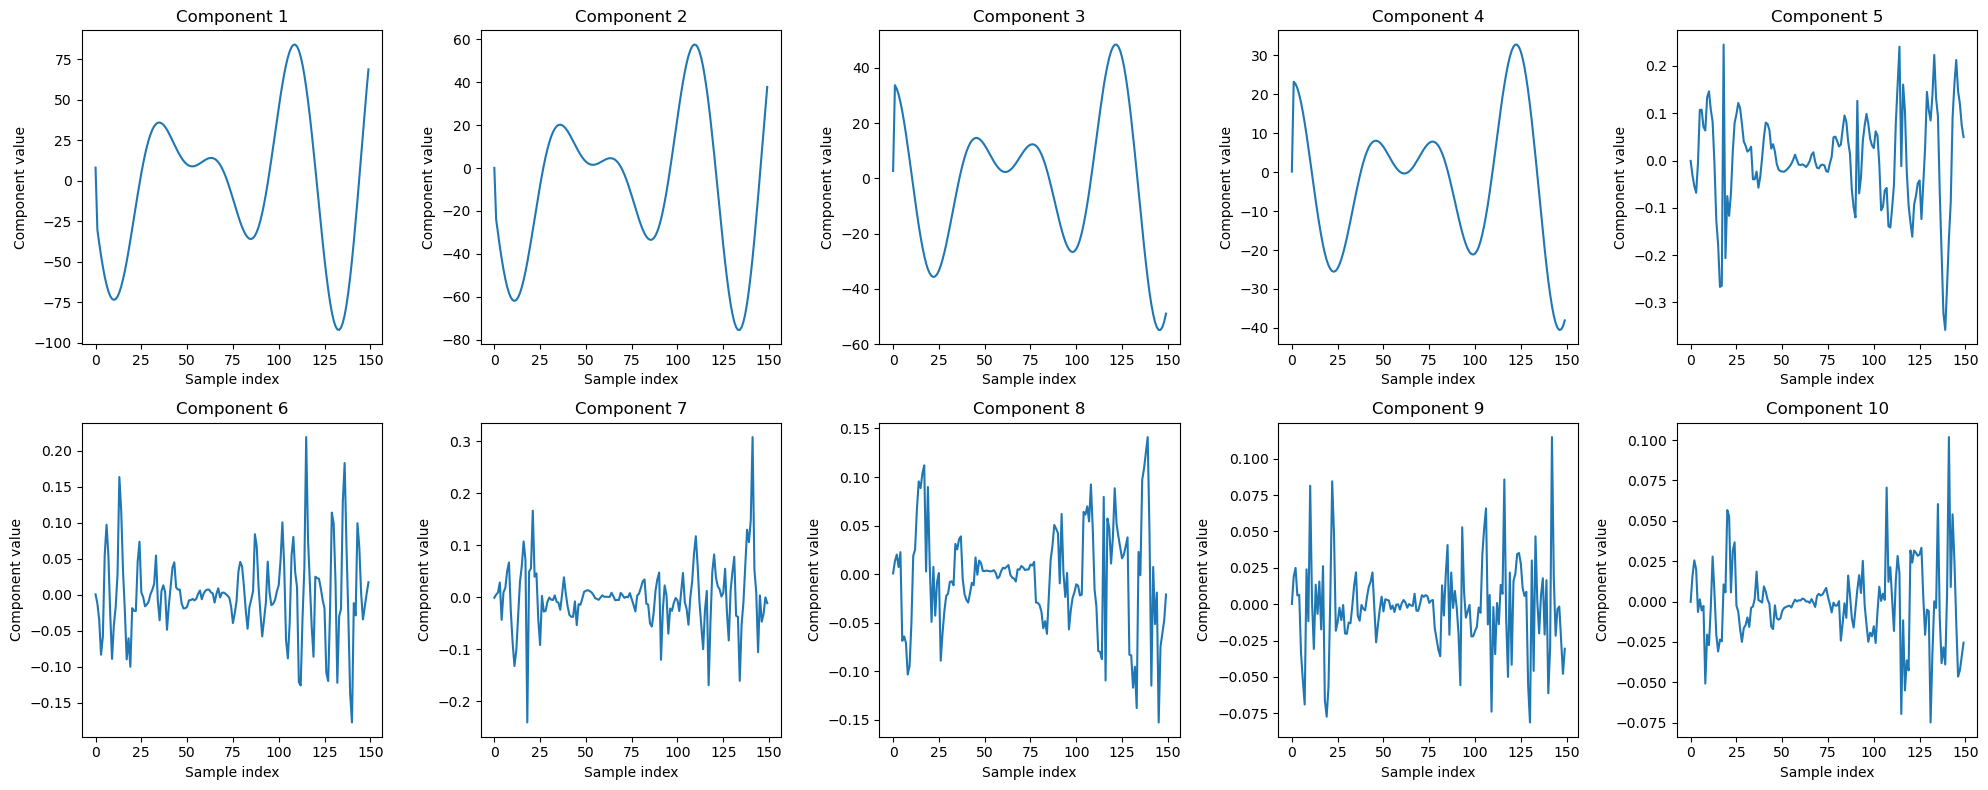

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Plotting the first 150 samples of each PCA component in a row of 5 subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
for i in range(10):
    row = i // 5  # Determining the row of the subplot
    col = i % 5   # Determining the column of the subplot
    axes[row, col].plot(x_pca[:150, i])  # Corrected to plot with dots for clarity
    axes[row, col].set_title(f'Component {i+1}')
    axes[row, col].set_xlabel('Sample index')
    axes[row, col].set_ylabel('Component value')

plt.tight_layout()
plt.show()
